In [1]:
import numpy as np
import seaborn as sns
import struct
import pymysql
import pymysql.cursors
import matplotlib.pyplot as plt

### Acquire data from sql

In [2]:
db = pymysql.connect(host='localhost',
                           user='root',
                           password='xzx970413',
                           db='Wechat_inf',
                           port=3306,
                           charset='utf8')

cur = db.cursor()

sql = "select * from User_inf"
try:
	cur.execute(sql) 
 
	results = cur.fetchall()
	print("id","borrow","repay")
	#遍历结果
	for row in results :
		id = row[0]
		name = int.from_bytes(row[-2], byteorder='little', signed=True) - 48
		password = int.from_bytes(row[-1], byteorder='little', signed=True) - 48
        #password = row[-1].decode("utf-8") 
		print(id,name,password)
except Exception as e:
	raise e
finally:
	db.close()


id borrow repay
1435223 1 0
172344 1 1
18661377320 1 0
1927233 1 1
234567 1 0
25233 1 1
2667623 0 1
34332423 0 1
657851236 1 1
7223654 0 0
783423 0 1


### Preprocess data

In [3]:
from pandas import DataFrame
data  = DataFrame(list(results))
print (data.describe().T)

   count  mean       std   min    25%   50%    75%   max
1   10.0  34.0  8.151346  21.0  27.25  37.5  40.75  43.0
2   10.0   9.4  7.244922   0.0   2.75  11.0  14.50  20.0


#### Change bytes to int

In [4]:
data.columns = np.asarray(cur.description)[:, 0]
data['Borrow'] = data['Borrow'].map(lambda x: int.from_bytes(x, byteorder='little', 
                                                             signed=True) - 48)
data['Repay'] = data['Repay'].map(lambda x: int.from_bytes(x, byteorder='little', 
                                                           signed=True) - 48)
data

,User_id,User_Age,User_Work_year,Income,Debt,Borrow,Repay
0,1435223,24.0,2.0,28.00,17.30,1,0
1,172344,40.0,15.0,120.00,2.90,1,1
2,18661377320,NaN,NaN,0.00,0.00,1,0
3,1927233,43.0,12.0,38.00,3.60,1,1
4,234567,41.0,17.0,176.00,9.30,1,0
5,25233,39.0,20.0,67.00,30.60,1,1
6,2667623,28.0,10.0,31.00,17.30,0,1
7,34332423,27.0,0.0,16.00,1.70,0,1
8,657851236,21.0,0.0,0.00,0.00,1,1
9,7223654,36.0,13.0,25.00,19.70,0,0


#### Delete rows that has NaN data

In [6]:
nan_index = []

for i in range(data.shape[0]):
    if (data.iloc[i].isna().any()):
        print(i)
        nan_index.append(i)

data = data.drop(nan_index, axis = 0)

data

,User_id,User_Age,User_Work_year,Income,Debt,Borrow,Repay
0,1435223,24.0,2.0,28.00,17.30,1,0
1,172344,40.0,15.0,120.00,2.90,1,1
3,1927233,43.0,12.0,38.00,3.60,1,1
4,234567,41.0,17.0,176.00,9.30,1,0
5,25233,39.0,20.0,67.00,30.60,1,1
6,2667623,28.0,10.0,31.00,17.30,0,1
7,34332423,27.0,0.0,16.00,1.70,0,1
8,657851236,21.0,0.0,0.00,0.00,1,1
9,7223654,36.0,13.0,25.00,19.70,0,0
10,783423,41.0,5.0,25.00,10.20,0,1


#### Plot distribution of user age (e.g.)

/Users/macbook/miniconda3/envs/mlp/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


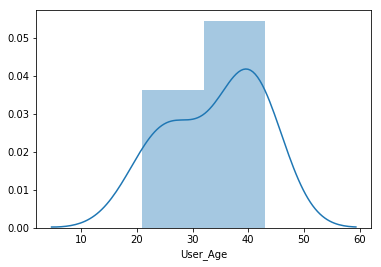

In [8]:
data_age = data[u'User_Age'].dropna()
sns.distplot(data_age)
plt.rcParams['axes.unicode_minus'] = False 

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1ae58908>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1ae3b978>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1ae58e10>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1ae3bcf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1ae600b8>],
 'means': []}

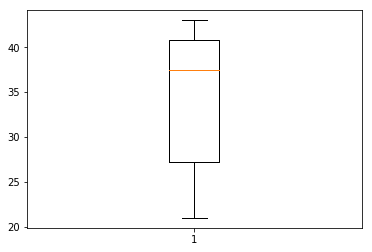

In [9]:
plt.boxplot(data_age)

#### Split columns to input and output

In [10]:
x = data.iloc[:, 1:5].values
y_borrow = data.iloc[:, 5].values
y_repay = data.iloc[:, 6].values

In [11]:
print(x)
print(y_borrow)
print(y_repay)

[[24.0 2.0 Decimal('28.00') Decimal('17.30')]
 [40.0 15.0 Decimal('120.00') Decimal('2.90')]
 [43.0 12.0 Decimal('38.00') Decimal('3.60')]
 [41.0 17.0 Decimal('176.00') Decimal('9.30')]
 [39.0 20.0 Decimal('67.00') Decimal('30.60')]
 [28.0 10.0 Decimal('31.00') Decimal('17.30')]
 [27.0 0.0 Decimal('16.00') Decimal('1.70')]
 [21.0 0.0 Decimal('0.00') Decimal('0.00')]
 [36.0 13.0 Decimal('25.00') Decimal('19.70')]
 [41.0 5.0 Decimal('25.00') Decimal('10.20')]]
[1 1 1 1 1 0 0 1 0 0]
[0 1 1 0 1 1 1 1 0 1]


#### Choose the feature
(lack: as the data is small, haven't use feature selection so far)
Just delete the data that has NaN

#### split dataset to training and test set

In [19]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split( x, y_borrow,
                                                         test_size = 0.2, 
                                                         stratify = y_borrow, 
                                                         random_state = 0)

X_train2, X_test2, y_train2, y_test2 = train_test_split( x, y_repay,
                                                         test_size = 0.2, 
                                                         stratify = y_repay, 
                                                         random_state = 0)

### Build the model

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Borrow model

In [34]:
# lbfgs - L2 regularization
model_borrow = LogisticRegression(solver='lbfgs')
model_borrow.fit(x, y_borrow)

y_predict1 = model_borrow.predict(X_test1)
accuracy = sum(y_test1 == y_predict1)/y_predict1.size
print(accuracy)
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.scatter(x.ravel(), y_borrow, color='black')
# # X_test = np.linspace(-5, 10, 300)

0.5


#### Repay model

In [35]:
model_repay = LogisticRegression(solver='lbfgs')
model_repay.fit(x, y_repay)

y_predict2 = model_repay.predict(X_test2)
accuracy = sum(y_test2 == y_predict2)/y_predict2.size
print(accuracy)

1.0
